In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Loading the data

In [63]:
df = pd.read_csv('Awma_data.csv')[['AWMA_Digit_Recall_Standard', 'AWMA_Dot_Matrix_Standard',
       'AWMA_Backward_Digit__Standard', 'AWMA_Mr_X__Standard']]

Forcing all variables to numeric

In [4]:
for variable in df.columns.values:
    df[variable] = df[variable].astype(str).convert_objects(convert_numeric=True)

Removing NaNs

In [5]:
df = df.dropna()

## 1. Distance matrices

In [33]:
labels = ['DigitRecall', 'DotMatrix', 'BackwardRecall', 'MrX']

In [32]:
def plot_similarity_matrix(matrix, vmin, vmax, labels):
    plt.imshow(matrix, interpolation='none', vmin=vmin, vmax=vmax, cmap='summer')
    ax = plt.gca()
    ax.set_xticks(np.arange(0,4))
    ax.set_yticks(np.arange(0,4))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticklabels(labels)
    plt.colorbar()
    plt.show()

### 1.1. Correlation

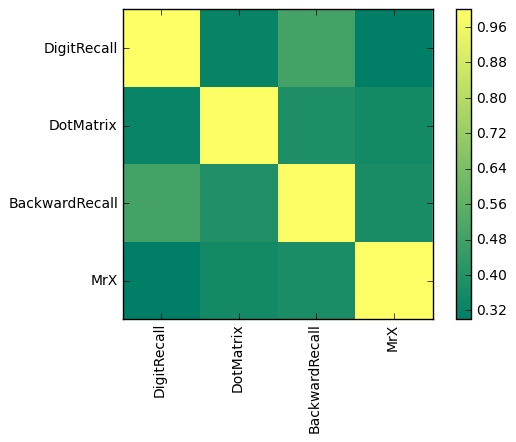

In [34]:
corr = df.corr().values
plot_similarity_matrix(corr, 0.3, 1, labels)

### 1.2. Partial correlation

In [8]:
from scipy.stats import pearsonr
import statsmodels.api as sm

par_corrs = list()

for i in range(0, len(df.columns)):
    for j in range(0, len(df.columns)):
        X = df.values
        indices = np.arange(0,len(df.columns))

        # Regressing other variables
        other_variables = indices[np.in1d(indices, [i, j], invert=True)]
        resid_i = sm.OLS(X[:,i], X[:, indices]).fit().resid
        resid_j = sm.OLS(X[:,j], X[:, indices]).fit().resid
        
        # Getting the correlation between the residuals
        par_corrs.append(pearsonr(resid_i, resid_j)[0])
        
par_corrs = np.reshape(np.asarray(par_corrs), newshape=[len(df.columns), len(df.columns)])

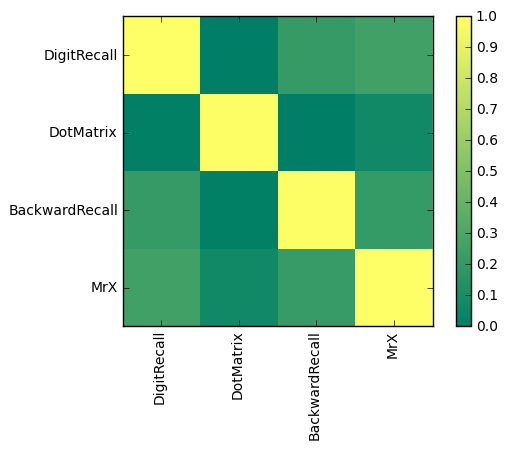

In [35]:
plot_similarity_matrix(par_corrs, 0, 1, labels)

### 1.3. Euclidean distance

In [10]:
from scipy.spatial.distance import euclidean

distances = list()

for s in df.columns:
    for i in df.columns:
        distances.append(euclidean(df[s],df[i]))
        
distances = np.reshape(np.asarray(distances), newshape=[len(df.columns), len(df.columns)])
distances = np.ones(shape=distances.shape) - distances/np.max(distances)

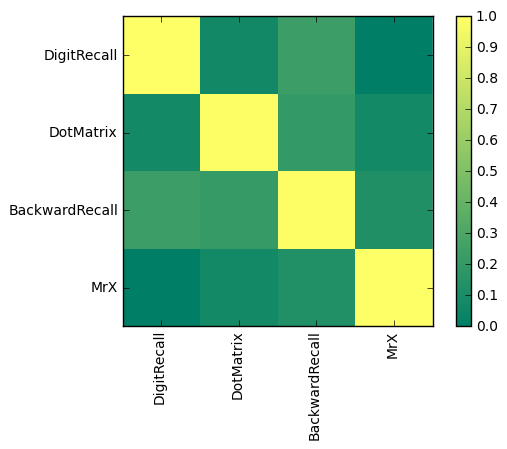

In [36]:
plot_similarity_matrix(distances, 0, 1, labels)

### 1.4. Mutual information

In [12]:
from sklearn.metrics import normalized_mutual_info_score

mut_infos = list()

for s in df.columns:
    for i in df.columns:
        mut_infos.append(normalized_mutual_info_score(df[s],df[i]))
        
mut_infos = np.reshape(np.asarray(mut_infos), newshape=[len(df.columns), len(df.columns)])

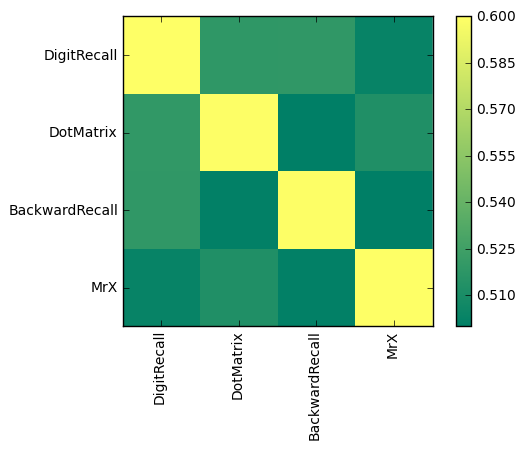

In [37]:
plot_similarity_matrix(mut_infos, 0.5, 0.6, labels)

## Overview of the matrices

![Overview](AWMA_Distance_Matrices/AWMA_Distance_Matrices.001.png)

This list is not comprehensive and can be extended. For instance, there are multiple ways of defining spatial distance, e.g. block distance.

## 2. Clustering

In [59]:
from sklearn.model_selection import train_test_split
X = df.values

ImportError: No module named model_selection

In [62]:
import sklearn
sklearn.__version__

'0.16.1'

### 2.1 K-means clustering

In [18]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(corr)

In [22]:
kmeans.labels_

array([0, 1, 0, 1], dtype=int32)

In [26]:
new_order = [i[0] for i in sorted(enumerate(kmeans.labels_), key=lambda x:x[1])]

In [55]:
newcorr = corr[new_order, :]
newcorr = newcorr[:, new_order]
newlabels = np.asarray(labels)[new_order]

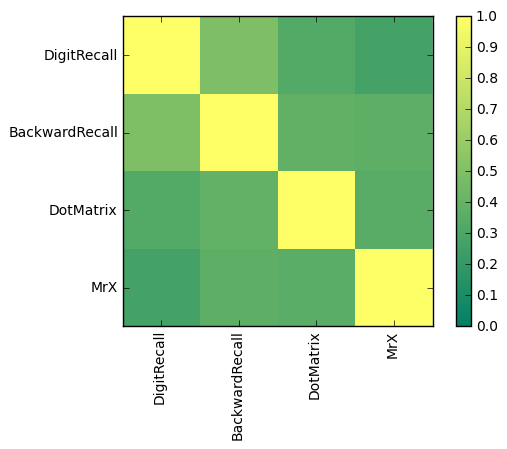

In [56]:
plot_similarity_matrix(newcorr, 0, 1, newlabels)